# Simulation for accounting for individuals

In [1]:
import scipy.stats as stats
import numpy as np
import pandas as pd
from sklearn.linear_model import LinearRegression
import seaborn as sns
import statsmodels.formula.api as smf
import statsmodels.api as sm
import matplotlib.pyplot as plt

In [2]:
num_ind = 20
num_cell_per_ind = 1000
beta_geno = 1
beta_age = 1
ind_intercepts = stats.norm.rvs(scale=2, size=num_ind)
intercept = 10
geno = np.array([0 for i in range(int(num_ind/2))] + [1 for i in range(int(num_ind/2))])
age = stats.norm.rvs(scale=10, loc=30, size=num_ind)

### LMM vs pseudobulk

In [ ]:
num_trial = 100
num_effect_size = 30

lm_power = np.zeros(num_effect_size)
lmm_power = np.zeros(num_effect_size)
pseudobulk_power = np.zeros(num_effect_size)
effect_sizes = np.linspace(3,3.5, num_effect_size)

for jdx, effect_size in enumerate(effect_sizes):#enumerate(np.linspace(0.1, 2, num_effect_size)):
    
    lm_pv = np.zeros(num_trial)
    lmm_pv = np.zeros(num_trial)
    pseudob_pv = np.zeros(num_trial)

    for idx in range(num_trial):

        data = []
        for ind in range(num_ind):
            mu = intercept+effect_size*geno[ind]+beta_age*age[ind]+ind_intercepts[ind]
            data.append(stats.norm.rvs(loc=mu, scale=1, size=num_cell_per_ind))

        df = pd.DataFrame()
        df['expr'] = np.concatenate(data)
        df['geno'] = np.repeat(geno, num_cell_per_ind)
        df['age'] = np.repeat(age, num_cell_per_ind)
        df['ind'] = ['donor_' + str(x) for x in np.repeat(range(num_ind), num_cell_per_ind)]
        dummy_df = pd.get_dummies(df, drop_first=True)

        pseudobulks = df.groupby('ind')[['expr', 'geno', 'age']].mean()

        lm_pv[idx] = smf.ols("expr ~ geno + age", df).fit().pvalues['geno']
        lmm_pv[idx] = smf.mixedlm("expr ~ geno + age", df, groups=df["ind"]).fit().pvalues['geno']
        pseudob_pv[idx] = smf.ols("expr ~ geno + age", pseudobulks).fit().pvalues['geno']
        
    lm_power[jdx] = (lm_pv < 0.05).mean()
    lmm_power[jdx] = (lmm_pv < 0.05).mean()
    pseudobulk_power[jdx] = (pseudob_pv < 0.05).mean()

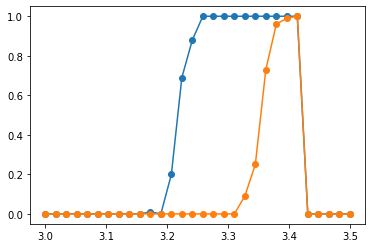

In [38]:
plt.plot(effect_sizes, lmm_power, '-o')
plt.plot(effect_sizes, pseudobulk_power, '-o')

### Compare LMM and hierarchial bootstrapping

In [5]:
data = []
for ind in range(num_ind):
    mu = intercept+beta_geno*geno[ind]+beta_age*age[ind]+ind_intercepts[ind]
    data.append(stats.norm.rvs(loc=mu, scale=1, size=num_cell_per_ind))

df = pd.DataFrame()
df['expr'] = np.concatenate(data)
df['geno'] = np.repeat(geno, num_cell_per_ind)
df['age'] = np.repeat(age, num_cell_per_ind)
df['ind'] = ['donor_' + str(x) for x in np.repeat(range(num_ind), num_cell_per_ind)]
dummy_df = pd.get_dummies(df, drop_first=True)

In [ ]:
dir(smf.mixedlm("expr ~ geno + age", df, groups=df["ind"]).fit())

### Hierarchial Bootstrapping

In [25]:
%%time

# actually bootstrap everything

lmm_result = []
boot_result = []

for univ in range(30):
    
    # Parameter generation
    num_ind = 20
    num_cell_per_ind = 1000
    beta_geno = 1
    beta_age = 1
    ind_intercepts = stats.norm.rvs(scale=2, size=num_ind)
    intercept = 10
    geno = np.array([0 for i in range(int(num_ind/2))] + [1 for i in range(int(num_ind/2))])
    age = stats.norm.rvs(scale=10, loc=30, size=num_ind)
    
    # Data generation
    data = []
    for ind in range(num_ind):
        mu = intercept+beta_geno*geno[ind]+beta_age*age[ind]+ind_intercepts[ind]
        data.append(stats.norm.rvs(loc=mu, scale=1, size=num_cell_per_ind))

    df = pd.DataFrame()
    df['expr'] = np.concatenate(data)
    df['geno'] = np.repeat(geno, num_cell_per_ind)
    df['age'] = np.repeat(age, num_cell_per_ind)
    df['ind'] = ['donor_' + str(x) for x in np.repeat(range(num_ind), num_cell_per_ind)]
    dummy_df = pd.get_dummies(df, drop_first=True)

    #LMM
    lmm_result.append(smf.mixedlm("expr ~ geno + age", df, groups=df["ind"]).fit())
    
    # bootstrap
    num_boot = 1000
    b_coefs = np.zeros(num_boot)
    for b in range(num_boot):
        b_donors = np.random.choice(num_ind, size=num_ind)
        genos = []
        exprs = []
        ages = []
        for d in b_donors:
            genos.append(np.ones(num_cell_per_ind)*int(d >= num_ind/2))
            b_idxs = np.random.choice(num_cell_per_ind, size=num_cell_per_ind)
            exprs.append(df.query('ind.str.contains("{}")'.format(d), engine='python').expr.values[b_idxs])
            ages.append(np.ones(num_cell_per_ind)*age[d])

        genos = np.concatenate(genos)
        exprs = np.concatenate(exprs)
        ages = np.concatenate(ages)
        b_coefs[b] = LinearRegression().fit(np.vstack([genos, ages]).T, exprs).coef_[0]
    boot_result.append(b_coefs)

    
    

CPU times: user 7h 53min 54s, sys: 27min 36s, total: 8h 21min 31s
Wall time: 1h 2min 41s


In [29]:
boot_ses = [np.std(boot_result[idx]) for idx in range(30)]

In [30]:
lmm_ses = [lmm_result[idx].bse['geno'] for idx in range(30)]

Text(0.5, 1.0, 'Hierarchial bootstrap vs LMM')

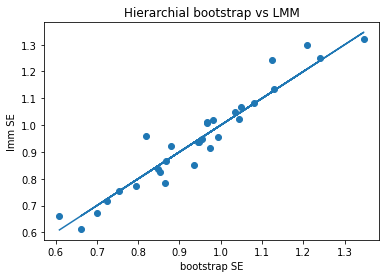

In [36]:
plt.scatter(boot_ses, lmm_ses)
# sns.regplot(boot_ses, lmm_ses)
plt.plot(boot_ses, boot_ses)
plt.xlabel('bootstrap SE'); plt.ylabel('lmm SE')
plt.title('Hierarchial bootstrap vs LMM')

### Sample distribution for variance

In [18]:
%%time

# actually bootstrap everything

lmm_result = []
boot_result = []

for univ in range(100):
    
    # Parameter generation
    num_ind = 20
    num_cell_per_ind = 1000
    beta_geno = 1
    beta_age = 1
    ind_intercepts = stats.norm.rvs(scale=2, size=num_ind)
    intercept = 10
    geno = np.array([0 for i in range(int(num_ind/2))] + [1 for i in range(int(num_ind/2))])
    age = stats.norm.rvs(scale=10, loc=30, size=num_ind)
    
    # Data generation
    geno_col = np.repeat(geno, num_cell_per_ind)
    age_col = np.repeat(age, num_cell_per_ind)
    intercept_col = np.repeat(ind_intercepts, num_cell_per_ind)
    expr_col = (stats.norm.rvs(loc=5, scale=intercept+beta_geno*geno_col+beta_age*age_col+intercept_col)-5)**2
    
    df = pd.get_dummies(pd.DataFrame(
        np.vstack([geno_col, age_col, expr_col, intercept_col]).T,
        index=['donor_' + str(x) for x in np.repeat(range(num_ind), num_cell_per_ind)],
        columns=['geno', 'age', 'expr', 'intercept']), drop_first=True)
    
    # bootstrap
    num_boot = 100
    b_coefs = np.zeros(num_boot)
    for b in range(num_boot):
        b_donors = np.random.choice(num_ind, size=num_ind)
        genos = []
        exprs = []
        ages = []
        for d in b_donors:
            genos.append(np.ones(num_cell_per_ind)*int(d >= num_ind/2))
            b_idxs = np.random.choice(num_cell_per_ind, size=num_cell_per_ind)
            exprs.append(df.loc['donor_'+str(d)].expr.values[b_idxs])
            ages.append(np.ones(num_cell_per_ind)*age[d])

        genos = np.concatenate(genos)
        exprs = np.concatenate(exprs)
        ages = np.concatenate(ages)
        b_coefs[b] = LinearRegression().fit(np.vstack([genos, ages]).T, exprs).coef_[0]
    boot_result.append(b_coefs)

    
    

CPU times: user 2h 4min 40s, sys: 3min 22s, total: 2h 8min 2s
Wall time: 2min 40s


(array([ 1.,  1.,  4.,  8., 22., 21., 13., 18.,  8.,  4.]),
 array([-3.09599933, -2.5734817 , -2.05096407, -1.52844644, -1.0059288 ,
        -0.48341117,  0.03910646,  0.56162409,  1.08414173,  1.60665936,
         2.12917699]),
 <BarContainer object of 10 artists>)

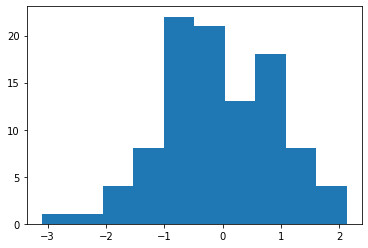

In [20]:
plt.hist(boot_result[0])

In [19]:
boot_result

[array([-0.17641492,  1.30043745, -0.48900076,  0.68057647, -1.7172874 ,
         0.63210114,  2.12917699, -0.26635408, -0.74503941,  1.14339833,
         0.12830738, -1.3525111 , -1.25117502,  0.97115137,  0.81961055,
         0.36755932, -2.52106201,  0.15186696,  1.0833689 , -0.64095374,
        -0.43287683,  0.06784483,  0.006862  ,  0.8904536 ,  2.03585478,
         1.38069309, -1.03837145, -0.01238419,  1.28692929, -3.09599933,
        -0.37949233, -0.73928321,  1.39143444, -0.55218354, -0.7761108 ,
        -0.63357608, -0.65288395, -0.01551259, -0.10408995, -0.17018014,
        -0.73449739,  0.04829424, -0.64458514, -1.22878855,  0.81535338,
        -0.13192697,  1.15865538,  1.80848777,  0.46968034, -0.35742401,
        -0.30139641, -0.13340714,  0.56989117, -1.14949357, -0.47185658,
        -0.62128076, -0.75848062,  1.077635  , -0.9908702 , -0.96202338,
         1.20890177,  0.45707966, -0.02304859,  1.76088142, -0.67551236,
         0.96995357,  0.5713133 , -0.43934139,  1.1

### Development for memento

In [87]:
%%time

for i in range(10000):
    b_coefs[b] = LinearRegression(n_jobs=1).fit(df[['geno', 'age']], df['expr']).coef_[0]

CPU times: user 13 s, sys: 3.76 ms, total: 13 s
Wall time: 13 s


In [90]:
%%time
LinearRegression(n_jobs=1).fit(np.random.random(size=(90, 1)), np.random.random(size=(90, 1)))

CPU times: user 1.58 ms, sys: 99 µs, total: 1.68 ms
Wall time: 1.32 ms


LinearRegression(n_jobs=1)

In [89]:
%%time
LinearRegression(n_jobs=1).fit(np.random.random(size=(90, 1)), np.random.random(size=(90, 50000)))

CPU times: user 1.35 s, sys: 105 ms, total: 1.45 s
Wall time: 113 ms


LinearRegression(n_jobs=1)

In [ ]:
b_coefs[b] = LinearRegression(n_jobs=1).fit(df[['geno', 'age']], df['expr']).coef_[0]

In [86]:
df.shape

(90, 4)

In [36]:
gen = np.random.Generator(np.random.PCG64(5))

In [63]:
%%time
replicate_assignment = np.random.choice(10, size=(10, 1000))

CPU times: user 571 µs, sys: 0 ns, total: 571 µs
Wall time: 368 µs


In [64]:
b_iter_assignment = np.random.choice(1000, (10, 1000))

In [65]:
replicate_assignment.shape

(10, 1000)

In [66]:
b_iter_assignment.shape

(10, 1000)

In [67]:
boot_expr = stats.norm.rvs(size=(10, 1000))

In [70]:
boot_expr[ ( replicate_assignment,  b_iter_assignment) ].shape

(10, 1000)

In [35]:
(b_coefs < 0).mean()

0.4196

### Tests

In [551]:
**(3,2)

SyntaxError: invalid syntax (1290438042.py, line 1)

In [564]:
def _cross_coef(A, B, sample_weight):
	
    # Rowwise mean of input arrays & subtract from input arrays themeselves
    A_mA = A - np.average(A, axis=0, weights=sample_weight)
    B_mB = B - np.average(B, axis=0, weights=sample_weight)

    # Sum of squares across rows
    ssA = np.average(A_mA**2, axis=0, weights=sample_weight)

    # Finally get corr coeff
    return A_mA.T.dot(np.diag(sample_weight)).dot(B_mB)/sample_weight.sum() / ssA[:, None]

def _cross_coef_resampled(A, B, sample_weight):
	
    B_mB = B - np.average(B, axis=0, weights=sample_weight)
    A_mA = A - (A*sample_weight[:, :, np.newaxis]).sum(axis=0)/sample_weight.sum(axis=0)[:, np.newaxis]

    # Sum of squares across rows
    ssA = (A_mA**2*sample_weight[:, :, np.newaxis]).sum(axis=0)/sample_weight.sum(axis=0)[:, np.newaxis]

    # temp = np.einsum( 'ij,ijk->kj',  (boot_expr_resampled * weights_resampled), snps_resampled)
    return np.einsum('ijk,ij->jk', A_mA * sample_weight[:, :, np.newaxis], B_mB).T/sample_weight.sum(axis=0) / ssA.T

In [565]:
boot_expr = stats.norm.rvs(size=(90, 10000))
snps = np.random.randint(3, size=(90, 5))
weights = stats.norm.rvs(loc=100, scale=10, size=90).astype(int)

In [566]:
b_iter_assignment

array([[   0,    1,    2, ..., 9997, 9998, 9999],
       [   0,    1,    2, ..., 9997, 9998, 9999],
       [   0,    1,    2, ..., 9997, 9998, 9999],
       ...,
       [   0,    1,    2, ..., 9997, 9998, 9999],
       [   0,    1,    2, ..., 9997, 9998, 9999],
       [   0,    1,    2, ..., 9997, 9998, 9999]])

In [567]:
replicate_assignment 

array([[ 0,  0,  0, ...,  0,  0,  0],
       [ 1,  1,  1, ...,  1,  1,  1],
       [ 2,  2,  2, ...,  2,  2,  2],
       ...,
       [87, 87, 87, ..., 87, 87, 87],
       [88, 88, 88, ..., 88, 88, 88],
       [89, 89, 89, ..., 89, 89, 89]])

In [568]:
%%time
# without replicate resampling
no_resampling = _cross_coef(snps, boot_expr, weights)

CPU times: user 22.3 ms, sys: 9.11 ms, total: 31.4 ms
Wall time: 7.24 ms


In [569]:
%%time
# with replicate resampling

boot_expr_resampled = boot_expr[(replicate_assignment, b_iter_assignment)]
snps_resampled = snps[replicate_assignment]
weights_resampled = weights[replicate_assignment]

resampling = _cross_coef_resampled(snps_resampled, boot_expr_resampled, weights_resampled)

CPU times: user 80 ms, sys: 52.3 ms, total: 132 ms
Wall time: 130 ms


In [570]:
no_resampling

array([[-0.05988117, -0.06171054, -0.18698852, ...,  0.01170044,
         0.04763177,  0.0125007 ],
       [-0.11455263,  0.20160014,  0.03180563, ..., -0.0733824 ,
        -0.07433392,  0.09746808],
       [-0.11609546, -0.05078757,  0.01429696, ...,  0.05883788,
         0.12252083,  0.18119641],
       [ 0.13999893, -0.0980006 , -0.20078233, ..., -0.1065617 ,
        -0.14043933,  0.07974735],
       [ 0.13787341,  0.11843598, -0.14769709, ...,  0.0245258 ,
         0.01665072, -0.2290527 ]])

In [571]:
resampling

array([[-0.05988117, -0.06171054, -0.18698852, ...,  0.01170044,
         0.04763177,  0.0125007 ],
       [-0.11455263,  0.20160014,  0.03180563, ..., -0.0733824 ,
        -0.07433392,  0.09746808],
       [-0.11609546, -0.05078757,  0.01429696, ...,  0.05883788,
         0.12252083,  0.18119641],
       [ 0.13999893, -0.0980006 , -0.20078233, ..., -0.1065617 ,
        -0.14043933,  0.07974735],
       [ 0.13787341,  0.11843598, -0.14769709, ...,  0.0245258 ,
         0.01665072, -0.2290527 ]])

In [528]:
A = snps
B = boot_expr
sample_weight = weights

# Rowwise mean of input arrays & subtract from input arrays themeselves
A_mA = A - np.average(A, axis=0, weights=sample_weight)
B_mB = B - np.average(B, axis=0, weights=sample_weight)

# Sum of squares across rows
ssA = np.average(A_mA**2, axis=0, weights=sample_weight)

temp1 = A_mA.T.dot(np.diag(sample_weight)).dot(B_mB)/sample_weight.sum() / ssA[:, None]


In [529]:
A = snps_resampled
B = boot_expr_resampled
sample_weight = weights_resampled 

B_mB = B - np.average(B, axis=0, weights=sample_weight)
A_mA = A - (A*weights_resampled[:, :, np.newaxis]).sum(axis=0)/weights_resampled.sum(axis=0)[:, np.newaxis]

# Sum of squares across rows
ssA = (A_mA**2*weights_resampled[:, :, np.newaxis]).sum(axis=0)/weights_resampled.sum(axis=0)[:, np.newaxis]

# temp = np.einsum( 'ij,ijk->kj',  (boot_expr_resampled * weights_resampled), snps_resampled)
temp2 = np.einsum('ijk,ij->jk', A_mA * weights_resampled[:, :, np.newaxis], B_mB).T/weights_resampled.sum(axis=0) / ssA.T

In [530]:
temp1

array([[ 0.11545594,  0.04942186,  0.13452439, ...,  0.01464543,
         0.20582413, -0.04256053],
       [ 0.15468237, -0.06566072, -0.01795627, ...,  0.10883713,
        -0.03191192,  0.23477685],
       [-0.04766101,  0.02481631,  0.02372452, ...,  0.15679898,
         0.14754772,  0.10074068],
       [-0.02021122,  0.03827843, -0.15005295, ...,  0.13735752,
        -0.1562774 , -0.02541735],
       [ 0.1593466 ,  0.08748821,  0.06035192, ..., -0.17126036,
        -0.05155565,  0.0073912 ]])

In [531]:
temp2

array([[ 0.11545594,  0.04942186,  0.13452439, ...,  0.01464543,
         0.20582413, -0.04256053],
       [ 0.15468237, -0.06566072, -0.01795627, ...,  0.10883713,
        -0.03191192,  0.23477685],
       [-0.04766101,  0.02481631,  0.02372452, ...,  0.15679898,
         0.14754772,  0.10074068],
       [-0.02021122,  0.03827843, -0.15005295, ...,  0.13735752,
        -0.1562774 , -0.02541735],
       [ 0.1593466 ,  0.08748821,  0.06035192, ..., -0.17126036,
        -0.05155565,  0.0073912 ]])

In [526]:
np.average(A, axis=0, weights=np.repeat(sample_weight[:, :, np.newaxis], A.shape[-1], axis=2))

array([[1.00231074, 0.99130722, 1.06800176, 1.04830546, 1.0587588 ],
       [1.00231074, 0.99130722, 1.06800176, 1.04830546, 1.0587588 ],
       [1.00231074, 0.99130722, 1.06800176, 1.04830546, 1.0587588 ],
       ...,
       [1.00231074, 0.99130722, 1.06800176, 1.04830546, 1.0587588 ],
       [1.00231074, 0.99130722, 1.06800176, 1.04830546, 1.0587588 ],
       [1.00231074, 0.99130722, 1.06800176, 1.04830546, 1.0587588 ]])

In [489]:
temp1

array([[ 0.11545594,  0.04942186,  0.13452439, ...,  0.01464543,
         0.20582413, -0.04256053],
       [ 0.15468237, -0.06566072, -0.01795627, ...,  0.10883713,
        -0.03191192,  0.23477685],
       [-0.04766101,  0.02481631,  0.02372452, ...,  0.15679898,
         0.14754772,  0.10074068],
       [-0.02021122,  0.03827843, -0.15005295, ...,  0.13735752,
        -0.1562774 , -0.02541735],
       [ 0.1593466 ,  0.08748821,  0.06035192, ..., -0.17126036,
        -0.05155565,  0.0073912 ]])

In [490]:
temp2

array([[ 0.11545594,  0.04942186,  0.13452439, ...,  0.01464543,
         0.20582413, -0.04256053],
       [ 0.15468237, -0.06566072, -0.01795627, ...,  0.10883713,
        -0.03191192,  0.23477685],
       [-0.04766101,  0.02481631,  0.02372452, ...,  0.15679898,
         0.14754772,  0.10074068],
       [-0.02021122,  0.03827843, -0.15005295, ...,  0.13735752,
        -0.1562774 , -0.02541735],
       [ 0.1593466 ,  0.08748821,  0.06035192, ..., -0.17126036,
        -0.05155565,  0.0073912 ]])

In [285]:

# with replicate resampling

boot_expr_resampled = boot_expr[(replicate_assignment, b_iter_assignment)]
snps_resampled = snps[replicate_assignment]
weights_resampled = weights[replicate_assignment]

b = _cross_coef_resampled(snps_resampled, boot_expr_resampled, weights_resampled)

<AxesSubplot:ylabel='Density'>

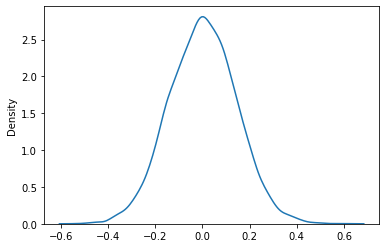

In [226]:
sns.kdeplot(coefs[:, 0])

In [184]:
snps_resampled.shape

(90, 10000, 5)

In [188]:
snps[replicate_assignment[:,0]][:5]

array([[1, 1, 0, 0, 2],
       [1, 1, 0, 2, 0],
       [0, 0, 0, 1, 0],
       [0, 1, 0, 1, 0],
       [0, 1, 0, 1, 0]])

In [186]:
snps_resampled[:, 0, :][:5]

array([[1, 1, 0, 0, 2],
       [1, 1, 0, 2, 0],
       [0, 0, 0, 1, 0],
       [0, 1, 0, 1, 0],
       [0, 1, 0, 1, 0]])

In [173]:
%%time

# just single bootstrap
boot_idx = 0
resampling = replicate_assignment[boot_idx]
b = _cross_coef(snps[resampling], boot_expr.T[boot_idx][resampling].reshape(-1,1), weights[resampling])

CPU times: user 1.17 ms, sys: 73 µs, total: 1.24 ms
Wall time: 858 µs


In [174]:
b.shape

(5, 1)

In [175]:
boot_expr.T[boot_idx][resampling].shape

(90,)

In [ ]:
def test(resampling, expr):
    
    return _cross_coef(snps[resampling], boot_expr.T[boot_idx][resampling].reshape(-1,1), weights[resampling])

In [103]:
X = np.array([1, 2, 3, 4, 5]).reshape(-1,1)
y = np.array([4, 2, 2, 5, 1])
weights = np.array([1, 2, 3, 1, 2])

In [104]:
LinearRegression(n_jobs=1).fit(X, y, weights).coef_

array([-0.35820896])

In [98]:
LinearRegression(n_jobs=1).fit(X, y, weights).coef_

array([-0.16666667])

### Permutation

<AxesSubplot:ylabel='Density'>

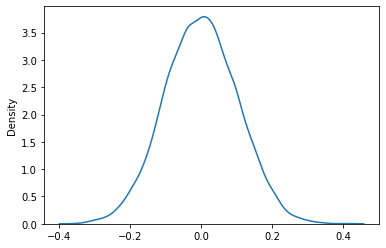

In [85]:
num_perm = 10000
p_coefs = np.zeros(num_perm)
for p in range(num_perm):
    
    p_idxs = np.random.choice(df.shape[0], size=df.shape[0], replace=False)
    p_coefs[p] = LinearRegression().fit(df[['geno']].values[p_idxs], df['expr'].values).coef_[0]
sns.kdeplot(p_coefs)

<AxesSubplot:ylabel='Density'>

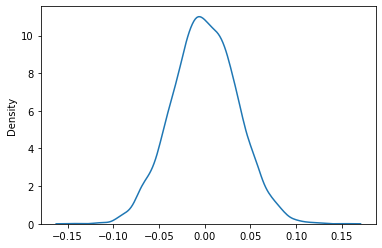

In [95]:
# Stratified permutation
num_perm = 10000
p_coefs2 = np.zeros(num_perm)

for p in range(num_perm):

    p_df = dummy_df.copy()
    p_df['geno'] = np.random.choice(dummy_df['geno'], size=df.shape[0], replace=False)
    p_coefs2[p] = LinearRegression().fit(p_df.iloc[:, 1:].values, p_df['expr'].values).coef_[0]
sns.kdeplot(p_coefs2)

### Hack

In [114]:
to_subtract0 = (df.query('geno == 0').groupby('ind').expr.mean() - df.query('geno == 0').groupby('ind').expr.mean().mean()).reset_index(name='to_subtract')
to_subtract1 = (df.query('geno == 1').groupby('ind').expr.mean() - df.query('geno == 1').groupby('ind').expr.mean().mean()).reset_index(name='to_subtract')
to_subtract = pd.concat([to_subtract0, to_subtract1])

In [118]:
hack_df = df.copy().merge(to_subtract, on='ind')

In [119]:
hack_df['centered_expr'] = hack_df['expr'] - hack_df['to_subtract']

In [122]:
hack_df.groupby('ind').centered_expr.mean()

ind
donor_0    8.380178
donor_1    8.380178
donor_2    8.380178
donor_3    8.380178
donor_4    8.380178
donor_5    9.280452
donor_6    9.280452
donor_7    9.280452
donor_8    9.280452
donor_9    9.280452
Name: centered_expr, dtype: float64

<AxesSubplot:ylabel='Density'>

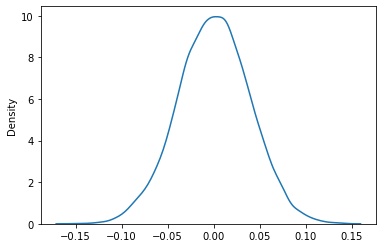

In [121]:
# permutation
num_perm = 10000
p_coefs = np.zeros(num_perm)
for p in range(num_perm):
    
    p_idxs = np.random.choice(hack_df.shape[0], size=hack_df.shape[0], replace=False)
    p_coefs[p] = LinearRegression().fit(hack_df[['geno']].values[p_idxs], hack_df['centered_expr'].values).coef_[0]
sns.kdeplot(p_coefs)

### sampling for permutation

In [11]:
expr = stats.norm.rvs(size=1000)

In [12]:
p1 = [0.4, 0.5, 0.1]
p2 = [0.4, 0.1, 0.5]
num_trial = 30000
p1_coefs = np.zeros(num_trial)
p2_coefs = np.zeros(num_trial)
for trial in range(num_trial):
    tx1 = np.random.choice([0, 1, 2], p=p1, size=1000)
    tx2 = np.random.choice([0, 1, 2], p=p2, size=1000)
    
    p1_coefs[trial] = stats.linregress(tx1, expr)[0]
    p2_coefs[trial] = stats.linregress(tx2, expr)[0]

<AxesSubplot:ylabel='Density'>

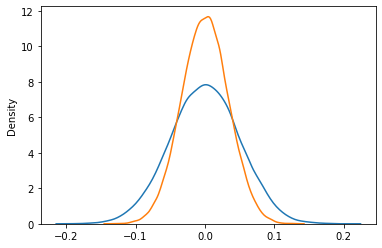

In [13]:
sns.kdeplot(p1_coefs)
sns.kdeplot(p2_coefs)